In [1]:
import glob
import torch
import torchvision.models
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn



In [2]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
#pip install torchvision
from torchvision import transforms, models, datasets
#https://pytorch.org/docs/stable/torchvision/index.html
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

In [3]:
data_dir = 'F:/Learning/DS_year1/mfe204/ref_topic02_PathPlanning/pic'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/test'

In [4]:
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转 选择一个概率概率
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),#概率转换成灰度率，3通道就是R=G=B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#均值，标准差
    ]),
    'test': transforms.Compose([transforms.Resize(32),
        transforms.ToTensor(),
        transforms.CenterCrop(32),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
batch_size = 10

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [6]:
with open('F:/Learning/DS_year1/mfe204/ref_topic02_PathPlanning/pic/name.json') as f:
    cat_to_name = json.load(f)

In [7]:
cat_to_name

{'0': 'female', '1': 'male'}

In [8]:
img_batch, label_batch = next(iter(dataloaders['train']))
print(img_batch.shape)

torch.Size([10, 3, 32, 32])


In [9]:
dataset_sizes

{'train': 1800, 'test': 180}

In [10]:
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

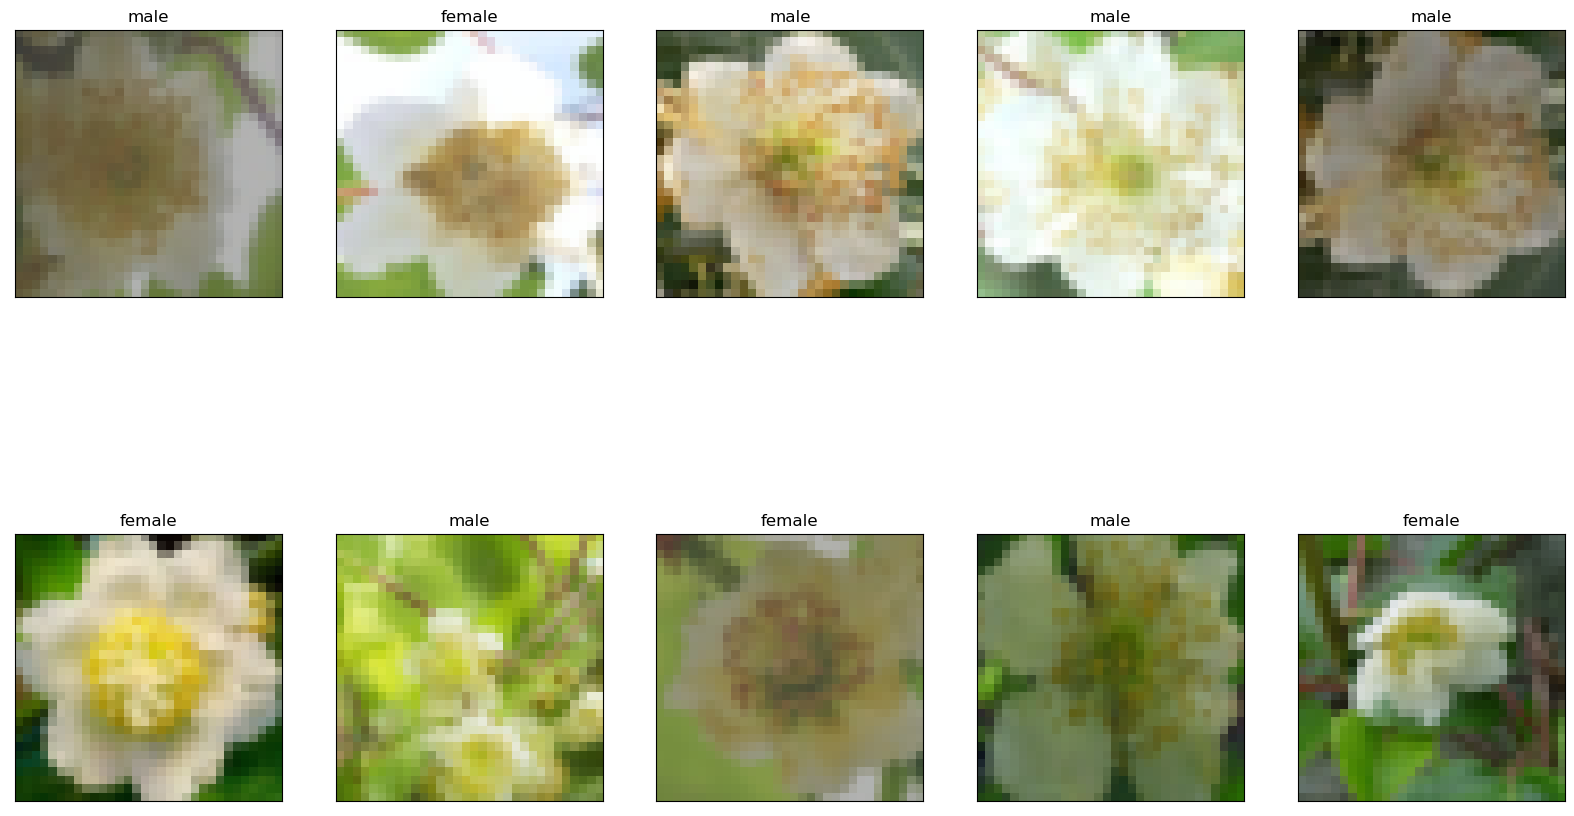

In [11]:
fig=plt.figure(figsize=(20, 12))
columns = 5
rows = 2

dataiter = iter(dataloaders['test'])
inputs, classes = dataiter.__next__()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx]))
plt.show()


In [12]:
from torchsummary import summary

if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
            
        x = x.view(-1, 32*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    # print model summary
lenet = LeNet().to(DEVICE)
summary(lenet, (3,32,32)) # summary code 

cpu
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 28, 28]          1,216
├─MaxPool2d: 1-2                         [-1, 16, 14, 14]          --
├─Conv2d: 1-3                            [-1, 32, 10, 10]          12,832
├─MaxPool2d: 1-4                         [-1, 32, 5, 5]            --
├─Linear: 1-5                            [-1, 120]                 96,120
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 10]                  850
Total params: 121,182
Trainable params: 121,182
Non-trainable params: 0
Total mult-adds (M): 2.33
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.46
Estimated Total Size (MB): 0.60


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 28, 28]          1,216
├─MaxPool2d: 1-2                         [-1, 16, 14, 14]          --
├─Conv2d: 1-3                            [-1, 32, 10, 10]          12,832
├─MaxPool2d: 1-4                         [-1, 32, 5, 5]            --
├─Linear: 1-5                            [-1, 120]                 96,120
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 10]                  850
Total params: 121,182
Trainable params: 121,182
Non-trainable params: 0
Total mult-adds (M): 2.33
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.46
Estimated Total Size (MB): 0.60

In [13]:
net = LeNet()           
print(net)
#定义优化函数和损失函数
if torch.cuda.is_available():
    net.to('cuda')
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters(), lr=0.003)

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [14]:
def fit(epoch, model, trainloader, testloader):
    corret = 0
    total = 0
    running_loss = 0

    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            y = torch.tensor(y, dtype=torch.long)
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            corret = corret +(y_pred == y).sum().item()
            total = total + y.size(0)
            running_loss = running_loss + loss.item()

    epoch_loss = running_loss/len(trainloader.dataset)      
    epoch_acc = corret/total

    test_correct = 0
    test_total = 0
    test_running_loss = 0
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            y = torch.tensor(y, dtype=torch.long)
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred =torch.argmax(y_pred, dim=1)
            test_correct = test_correct + (y_pred == y).sum().item()
            test_total = test_total + y.size(0)
            test_running_loss = test_running_loss + loss.item()
    epoch_test_loss = test_running_loss / len(testloader.dataset)  
    epoch_test_acc = test_correct / test_total
    
    print('epoch:', epoch,
          'loss:', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss', round(epoch_test_loss, 3),
          'test_accuracy', round(epoch_test_acc, 3)
        )

    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc


In [15]:
epochs = 50
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch, net, dataloaders['train'], dataloaders['test'])

    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)


C:\Users\wangyiyi\AppData\Local\Temp\ipykernel_13252\1291039568.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


epoch: 0 loss: 0.065 accuracy: 0.616 test_loss 0.063 test_accuracy 0.728
epoch: 1 loss: 0.042 accuracy: 0.815 test_loss 0.054 test_accuracy 0.761
epoch: 2 loss: 0.037 accuracy: 0.834 test_loss 0.056 test_accuracy 0.783
epoch: 3 loss: 0.032 accuracy: 0.857 test_loss 0.048 test_accuracy 0.861
epoch: 4 loss: 0.033 accuracy: 0.864 test_loss 0.045 test_accuracy 0.844
epoch: 5 loss: 0.024 accuracy: 0.9 test_loss 0.057 test_accuracy 0.883
epoch: 6 loss: 0.026 accuracy: 0.896 test_loss 0.073 test_accuracy 0.856
epoch: 7 loss: 0.02 accuracy: 0.924 test_loss 0.04 test_accuracy 0.883
epoch: 8 loss: 0.018 accuracy: 0.929 test_loss 0.063 test_accuracy 0.867
epoch: 9 loss: 0.015 accuracy: 0.944 test_loss 0.078 test_accuracy 0.883
epoch: 10 loss: 0.015 accuracy: 0.947 test_loss 0.069 test_accuracy 0.9
epoch: 11 loss: 0.014 accuracy: 0.948 test_loss 0.063 test_accuracy 0.867
epoch: 12 loss: 0.013 accuracy: 0.958 test_loss 0.068 test_accuracy 0.828
epoch: 13 loss: 0.013 accuracy: 0.954 test_loss 0.057 

制作loss和acc曲线

In [16]:
def Save_to_Csv(data, file_name, Save_format = 'csv', Save_type = 'col'):
    # data
    # 输入为一个字典，格式： { '列名称': 数据,....} 
    # 列名即为CSV中数据对应的列名， 数据为一个列表
    
    # file_name 存储文件的名字
    # Save_format 为存储类型， 默认csv格式， 可改为 excel
    # Save_type 存储类型 默认按列存储， 否则按行存储
    
    # 默认存储在当前路径下
    
    import pandas as pd
    import numpy as np
    
    Name = []
    times = 0
 
    if Save_type == 'col':
        for name, List in data.items():
            Name.append(name)
            if times == 0:
                Data = np.array(List).reshape(-1,1)
            else:
                Data = np.hstack((Data, np.array(List).reshape(-1,1)))
                
            times += 1
            
        Pd_data = pd.DataFrame(columns=Name, data=Data) 
        
    else:
        for name, List in data.items():
            Name.append(name)
            if times == 0:
                Data = np.array(List)
            else:
                Data = np.vstack((Data, np.array(List)))
        
            times += 1
    
        Pd_data = pd.DataFrame(index=Name, data=Data)  
    
    if Save_format == 'csv':
        Pd_data.to_csv('./'+ file_name +'.csv',encoding='utf-8')
    else:
        Pd_data.to_excel('./'+ file_name +'.xls',encoding='utf-8')

In [17]:
result_data = {'train_loss':train_loss,'train_acc':train_acc,'test_loss':test_loss,'test_acc':test_acc}

Save_to_Csv(result_data, 'result_data', Save_format = 'csv', Save_type = 'col')

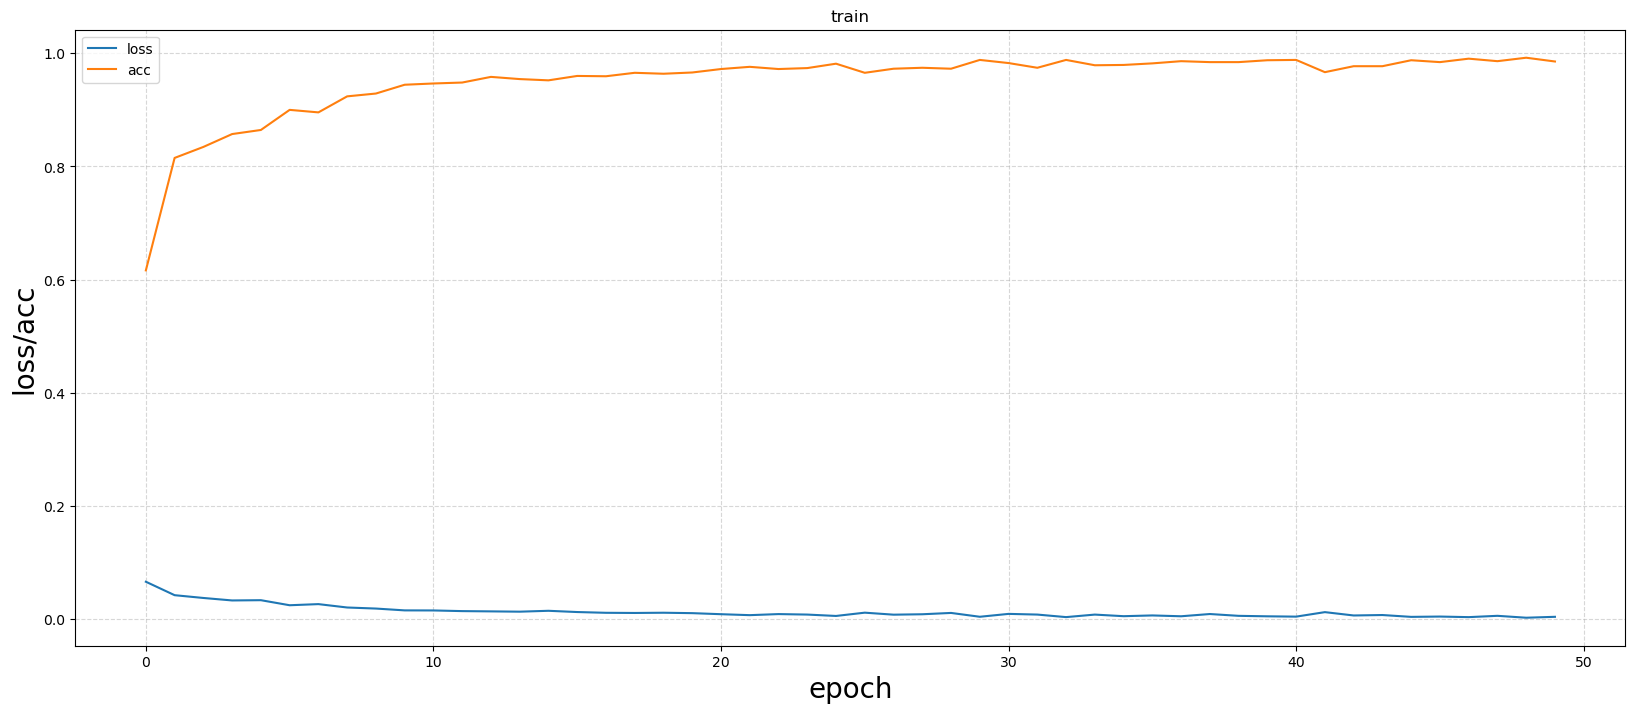

In [19]:
x=range(50)

y_train_loss=train_loss
y_train_acc =train_acc

plt.figure(figsize=(20,8),dpi=100)
plt.grid(True,linestyle='--',alpha=0.5) 

plt.plot(x,y_train_loss,label='loss')
plt.plot(x,y_train_acc,label='acc')

plt.xlabel("epoch",fontsize=20)
plt.ylabel("loss/acc",fontsize=20)
plt.title("train")

plt.savefig("train.png")

plt.legend(loc=0)

plt.show()

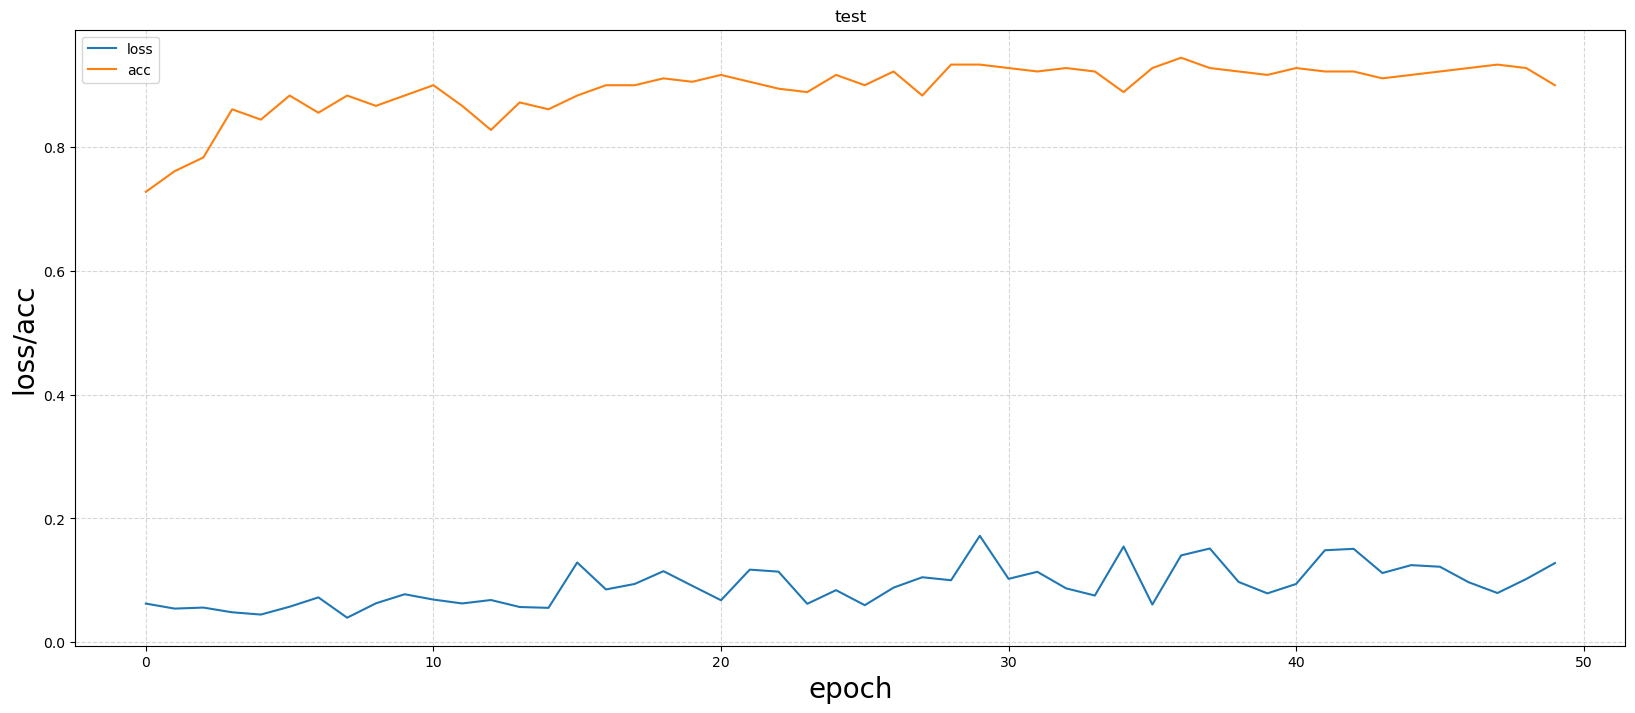

In [20]:

y_test_loss=test_loss
y_test_acc =test_acc

plt.figure(figsize=(20,8),dpi=100)
plt.grid(True,linestyle='--',alpha=0.5) 

plt.plot(x,y_test_loss,label='loss')
plt.plot(x,y_test_acc,label='acc')

plt.xlabel("epoch",fontsize=20)
plt.ylabel("loss/acc",fontsize=20)
plt.title("test")

plt.legend(loc=0)

plt.savefig("test.png")

plt.show()

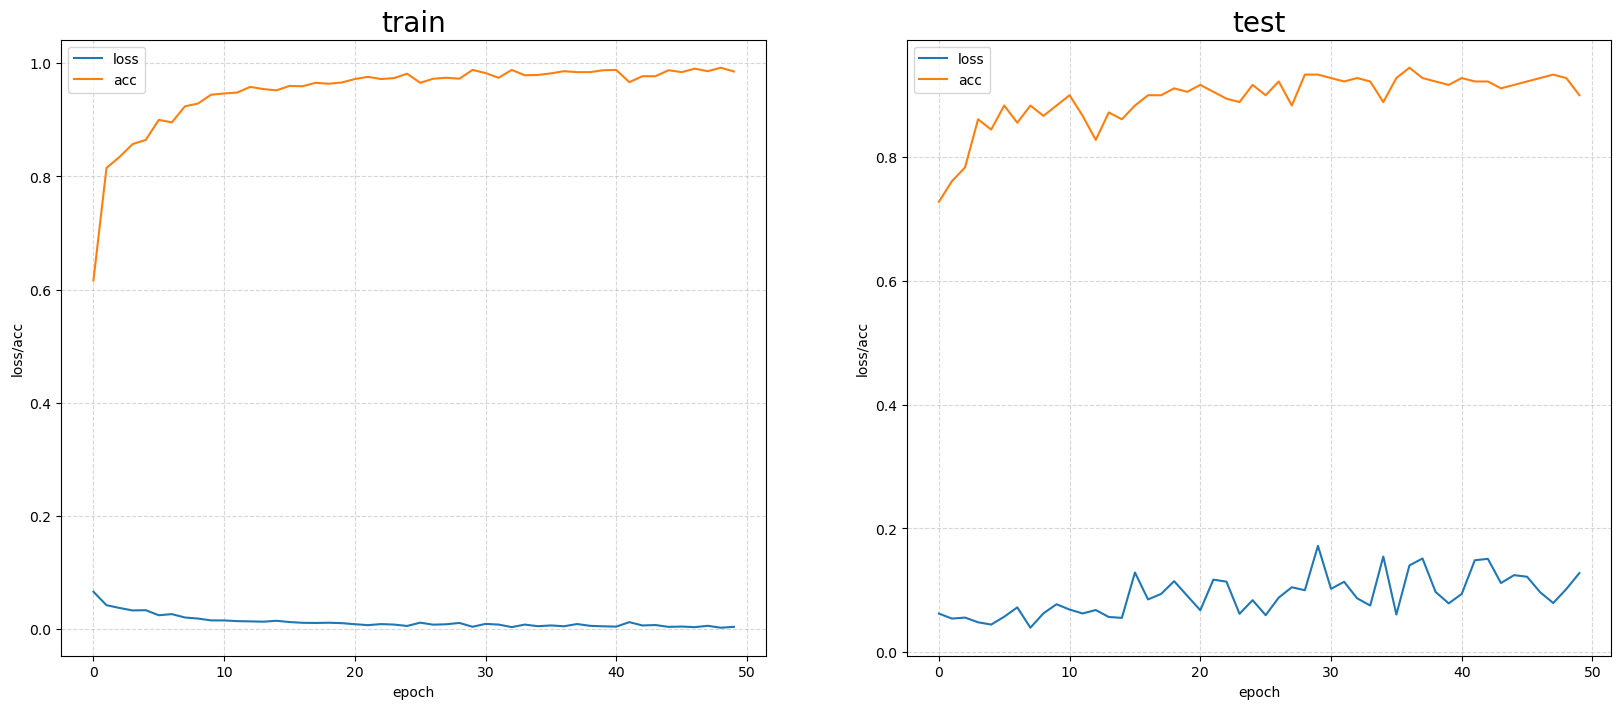

In [21]:


fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8),dpi=100)

axes[0].plot(x,y_train_loss,label='loss')
axes[0].plot(x,y_train_acc,label='acc')

axes[1].plot(x,y_test_loss,label='loss')
axes[1].plot(x,y_test_acc,label='acc')


axes[0].grid(True,linestyle="--",alpha=0.5)
axes[1].grid(True,linestyle="--",alpha=0.5)

axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss/acc")
axes[0].set_title("train",fontsize=20)
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("loss/acc")
axes[1].set_title("test",fontsize=20)

axes[0].legend(loc=0)
axes[1].legend(loc=0)

plt.savefig("result.png")
plt.show()



